# Inteligência Artificial - Trabalho
- Universidade Federal de Santa Catarina
- Departamento de Automação e Sistemas
- Prof. Eric Aislan Antonelo

### Grupo
-

### Opção: 1

#### 1. Implementação:
- Crie as estruturas de dados para guardar os pesos que definem uma arquitetura
de rede neural multi-camadas. Inicialize a rede neural aleatoriamente.
- Implemente o algoritmo da retropropagação para o cálculo do gradiente, a
derivada parcial da função de custo com relação aos pesos da rede.
- Valide o algoritmo do cálculo do gradiente, realizando uma aproximação numérica
do mesmo. Verifique se os cálculos batem um com o outro.
- Dado o gradiente já calculado, implemente o método do descenso do gradiente
para o treinamento da rede neural, ou seja, o processo de ajuste dos pesos.

#### 2. Aplicação:
- Use o código implementado para treinar uma rede neural para realizar a classificação de um padrão de duas dimensões de entrada. Os dados para treinamento
estão disponíveis no arquivo
classification2.txt.
Para plotar a fronteira de decisão da rede treinada, poderá usar o código
disponível no link
https://colab.research.google.com/drive/1XTtZGgpAefbiWejTrEjsnWzS_
XXYdzff?usp=sharing.
- Relate resultados variando pelo menos duas vezes cada um dos hiperparâmetros: o número de camadas; o número de neurônios por camada; taxa de aprendizagem. Use métricas como taxa de classificação (porcentagem de predições
corretas) no conjunto de validação (exemplos não usados no treinamento).
- (opcional) Treine uma rede neural para classificar dígitos a partir de imagens
como entrada para a rede. Use o arquivo
classification3.mat.

#### 3. Entregas:
No relatório a ser entregue, descreva os experimentos e os resultados obtidos.
Grave um video de até 3 minutos, onde você deve explicar o código implementado
de uma forma geral, as dificuldades encontradas, e em especial:
- a parte do código referente ao cálculo do gradiente
- a parte do código referente ao gradient descent
- o gráfico da fronteira de decisão
Entregue o código, PDF do relatório e o arquivo de video pelo Moodle (zipado com
ZIP ou tar.gz).

In [1]:
import pandas as pd
import numpy as np
import sys
import logging
from matplotlib import pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setFormatter(formatter)

logger.addHandler(stdout_handler)

### Data source

In [2]:
df = pd.read_csv('classification2.txt', header=None)
df.columns = ['column1', 'column2', 'label']
df.info()
print(f'\nLabel Value counts: \n{df.label.value_counts()}')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   column1  118 non-null    float64
 1   column2  118 non-null    float64
 2   label    118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB

Label Value counts: 
0    60
1    58
Name: label, dtype: int64


,column1,column2,label
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

# TODO: Scale data

### Neural net data structure

In [4]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],2) 
        self.weights2   = np.random.rand(2,1)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        
        print(self.weights1)
        print(self.weights2)

    def feedforward(self):
        self.layer1 = sigmoid(np.dot(self.input, self.weights1))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        delta = 2*(self.y - self.output) * sigmoid_derivative(self.output)
        d_weights2 = np.dot(self.layer1.T, delta)
        d_weights1 = np.dot(self.input.T,  delta, self.weights2.T) * sigmoid_derivative(self.layer1)

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

In [51]:
def relu(data):
    return np.maximum(0, data)
  
def sigmoid(data):
    return 1 / (1 + np.exp(-data)) 

def sigmoid_derivative(data):
    return data * (1 - data)

class Neuron():
    def __init__(self, input_length):
        # Include bias!
        self.__weights = self.create_random_weights(input_length)
        
    def create_random_weights(self, input_length):
        return np.random.randn(input_length)
        
    @property
    def weights(self):
        return self.__weights
    
    @weights.setter
    def weights(self, new_value):
        self.__weights = new_value
    
    def __repr__(self):
        return f'Neuron {self.weights}'
    
class Layer():
    def __init__(self, input_length, n_neurons):
        self.input_length = input_length
        self.n_neurons = n_neurons
        self.create_neurons()
        self.error_der = np.zeros((n_neurons, input_length))
    
    def create_neurons(self):
        """Creates neurons of layer
        """
        self.neurons = list()
        for i in range(self.n_neurons):
            self.neurons.append(
                Neuron(self.input_length)
            )
            
    def __repr__(self):
        return f'Layer \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([n.weights for n in self.neurons])
    
    @weights_matrix.setter
    def weights_matrix(self, new_weights):
        for neuron_i, neuron in enumerate(self.neurons):
            neuron.weights = new_weights[neuron_i]
    
    def transform(self, input_data, activation_function=sigmoid):
        """Calculates layer output based on input data
        """
        
        # Include bias
        #biased_input_data = np.ones((input_data.shape[0], input_data.shape[1] + 1))
        #biased_input_data[:, :-1] = input_data
        
        self.z = np.dot(input_data, self.weights_matrix.T)
        self.activation = activation_function(self.z)
        return self.activation

class NeuralNet():
    def __init__(self, *layers, learning_rate=0.1, epochs=5):
        self.layers = layers
        self.learning_rate = learning_rate
        self.costs = list()
        self.epochs = epochs
    
    def transform(self, X):
        X_transformed = X.copy()
        for layer in self.layers:
            X_transformed = layer.transform(X_transformed)
        
        return X_transformed
    
    def __repr__(self):
        return f'Neural Net \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([l.weights_matrix for l in self.layers], dtype=object)
    
    def cost(self, X, y):
        hx = np.array(self.transform(X).flat)
        log1_hx = np.log(hx)
        log2_hx = np.log(1 - hx)
        y_1 = np.multiply(log1_hx, y)
        y_0 = np.multiply((1 - y), log2_hx)
        return -np.sum(
            y_1 + y_0
        ) / X.shape[0]
    
    def backpropagate(self, sample, sample_i, hxi, label):
        logger.debug(f'\n\n+++++++++++++++')
        logger.debug(f'+++++++++++++++')
        logger.debug(f'+++++++++++++++')
        logger.debug(f'Starting backpropagration\n')
        logger.debug(f'Sample {sample}')
        logger.debug(f'Hxi {hxi}')
        logger.debug(f'Label {label}')
        
        reversed_layers = self.layers[::-1]
        previous_deltas = np.array([hxi - label])
        logger.debug(f'Initial Deltas: \n{previous_deltas}\n')
        
        for i, layer in enumerate(reversed_layers):
            logger.debug(f'\n-----------------')
            logger.debug(f'Index {i}, {layer}\n')
            logger.debug(f'Current Delta: \n{previous_deltas}\n')
            
            if (i+1) == len(reversed_layers):
                activation = sample
            else:
                activation = reversed_layers[i+1].activation[sample_i]

            transposed_weights = layer.weights_matrix.T
                
            logger.debug(f'Transposed weights: \n{transposed_weights}')
            logger.debug(f'Previous deltas: \n{previous_deltas}\n')
            
            delta_weights = np.dot(previous_deltas, layer.weights_matrix)
            sigmoid_derivate = sigmoid_derivative(activation)
            
            logger.debug(f'Delta Weights: \n{delta_weights}')
            logger.debug(f'Activation: \n{activation}')
            logger.debug(f'Sigmoid derivative: \n{sigmoid_derivate}\n')
            
            new_deltas = delta_weights * sigmoid_derivate
            logger.debug(f'New deltas: \n{new_deltas}\n')
            
            layer.error_der += np.outer(previous_deltas, activation)
            logger.debug(f'Error derivative: \n{layer.error_der}')
            
            previous_deltas = new_deltas # Exclude bias delta
            
            logger.debug('\n')
        
    def fit(self, X, y):
        hx = np.array(self.transform(X).flat)
        input_data = X[:]
        for epoch in range(self.epochs):
            logger.debug(f'Running epoch {epoch}')
            for sample_i, sample in enumerate(input_data):
                self.backpropagate(sample, sample_i, hx[sample_i], y[sample_i])
                for layer in self.layers:
                    layer.weights_matrix = layer.weights_matrix - self.learning_rate * layer.error_der / len(input_data)

                self.costs.append(self.cost(X, y))
        
        plt.plot(self.costs)
        plt.title('Cost through time')
        plt.ylabel('Cost')
        plt.show()

In [52]:
logger.setLevel(logging.INFO)
layers = [
    Layer(input_length=X.shape[1], n_neurons=3),
    Layer(input_length=3, n_neurons=1),
]

nn = NeuralNet(*layers, learning_rate=3, epochs=10)
print(nn)
print(f'Initial cost: {nn.cost(X, y)}')

Neural Net 
[array([[ 1.49084507,  0.20167094],
        [ 0.76943776, -0.45859597],
        [-1.39527514, -0.45078283]])
 array([[-0.22177301, -0.81925029, -0.15915028]])]
Initial cost: 0.7291618171594566


In [53]:
nn.cost(X, y)

0.7291618171594566

<ipython-input-51-6cb1a99e1198>:97: RuntimeWarning: divide by zero encountered in log
  log2_hx = np.log(1 - hx)
<ipython-input-51-6cb1a99e1198>:99: RuntimeWarning: invalid value encountered in multiply
  y_0 = np.multiply((1 - y), log2_hx)


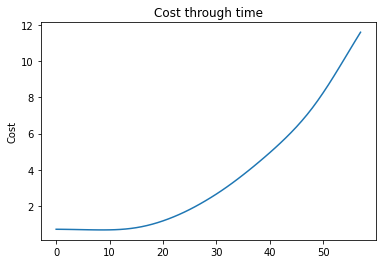

In [54]:
nn.fit(X, y)

In [ ]:
nn.layers[0].weights_matrix = np.array([
    [-.5, 2, 0.6],
])

In [ ]:
a = np.array([
    [1, 2, 3],
    [3, 4, 7],
])
b = np.array([1.5, 3, 4])
np.multiply(a, b)

In [ ]:
c = np.array([
    [1, 2, 3],
])
d = np.array([2, 3, 4])
np.dot(c, d)